#CAP 6315 - Social Networks and Big Data Analytics
## Project Part #1
### Jordan Winemiller - Z23962588

[*Colab Project Link*](https://colab.research.google.com/drive/1PBR3qY-72iEfz-Xa9Fxx154dKrOsx_8-)

[*GitHub Project Link*](https://github.com/jmwinemiller/fau-social-networks/tree/main/project)



This project with be using the [*Twitch Social Network*](https://snap.stanford.edu/data/twitch-social-networks.html) datasets, and be examining the Brazilian Portuguese language stream for our network.

In [67]:
# Setup and Imports
import random
import os
import zipfile

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from pyspark.sql import (
    SparkSession,
    Window,
)
import pyspark.sql.functions as F
import pyspark.sql.types as T
import seaborn as sns


SEED = 1234
LANG = "PTBR"
PATH = os.getcwd()
DATA_PATH = os.path.join(
    PATH,
    "twitch",
    LANG,
)


random.seed(SEED)
np.random.seed(SEED)

### Importing the data and creating PySpark session

#### Unzipping archive file

In [2]:
arhive_file = "twitch.zip"
with zipfile.ZipFile(os.path.join(PATH, arhive_file), "r") as archive_obj:
  archive_obj.extractall(PATH)

#### Creating the Spark Session and Loading the Dataset

In [3]:
spark = SparkSession.builder \
    .appName("ProjectPart-1") \
    .getOrCreate()

In [4]:
df = spark.read.csv(
    path=os.path.join(DATA_PATH, f"musae_{LANG}_edges.csv"),
    header=True,
    inferSchema=True
)
df.head(5)

[Row(from=0, to=92),
 Row(from=0, to=428),
 Row(from=1, to=689),
 Row(from=1, to=1147),
 Row(from=1, to=1666)]

#### Creating Graph with NetworkX

In [5]:
G = nx.Graph()

edges = df.collect()
G.add_edges_from([
    (row["from"], row["to"])
    for row in edges
])

#### Graph Visualization

In [6]:
plot_options = {
    "node_size": 10,
    "with_labels": False,
    "width": 0.15,
}

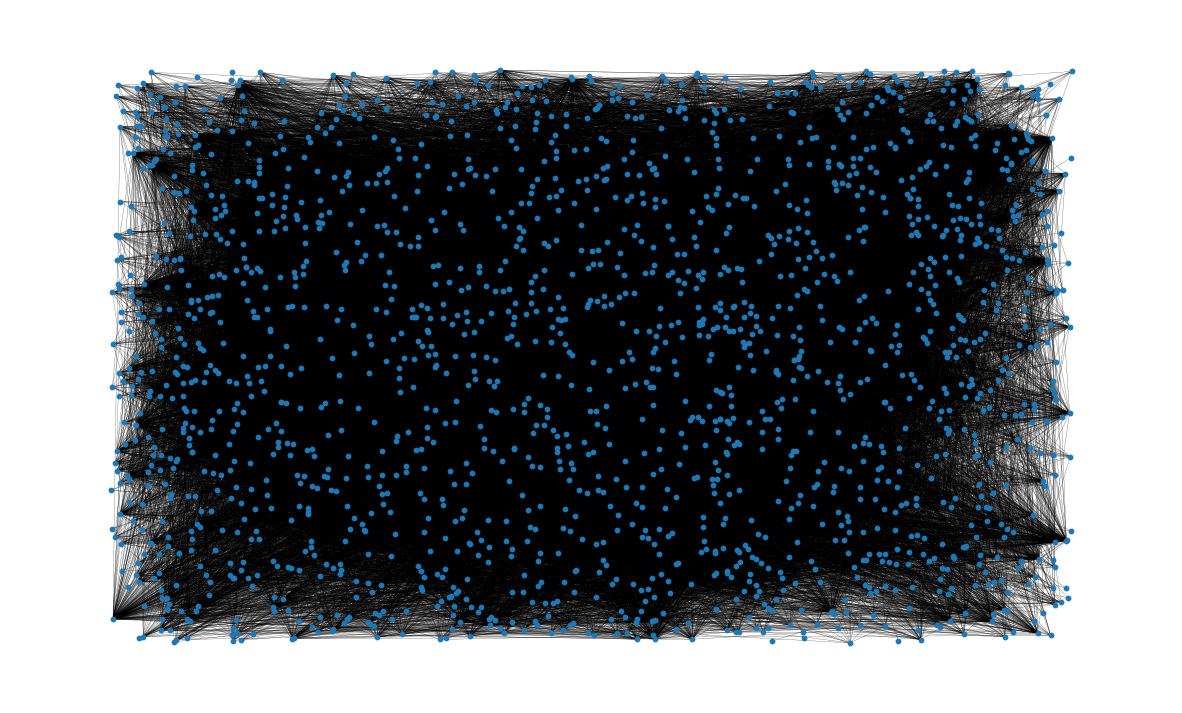

In [7]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(
    G,
    pos=nx.random_layout(G),
    ax=ax,
    **plot_options)

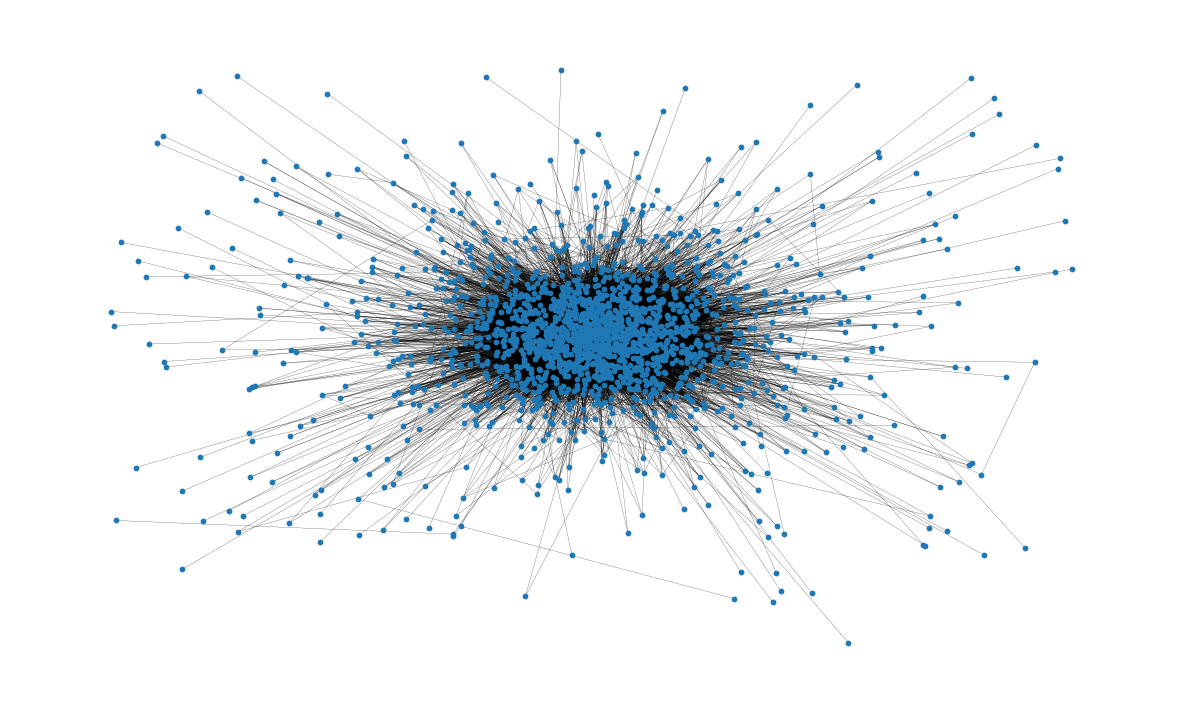

In [8]:
pos = nx.spring_layout(
    G,
    iterations=15,
    seed=SEED,
)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(
    G,
    pos=pos,
    ax=ax,
    **plot_options)

#### Calculate the Number of Nodes in the Graph

In [9]:
nn = G.number_of_nodes()
print(f"The Number of Nodes: {nn}")

The Number of Nodes: 1912


#### Calculate the Number of Edges in the Graph


In [10]:
ne = G.number_of_edges()
print(f"The Number of Edges: {ne}")

The Number of Edges: 31299


#### Calculate the Network Diameter

> Both methods are displayed

In [11]:
min_path_len = dict(nx.all_pairs_shortest_path_length(G))
diameter = max(nx.eccentricity(G, sp=min_path_len).values())

print(f"Diameter with Eccentrictiy Method: {diameter}")
print(f"Diameter with NetworkX: {nx.diameter(G)}")

Diameter with Eccentrictiy Method: 7
Diameter with NetworkX: 7


#### Network Diameter Interpretation

> The diameter of the network is **7**, which means that at most any user is
> **7** connections or friendships away from any other user in the network.

#### Histogram of Degree Distribution

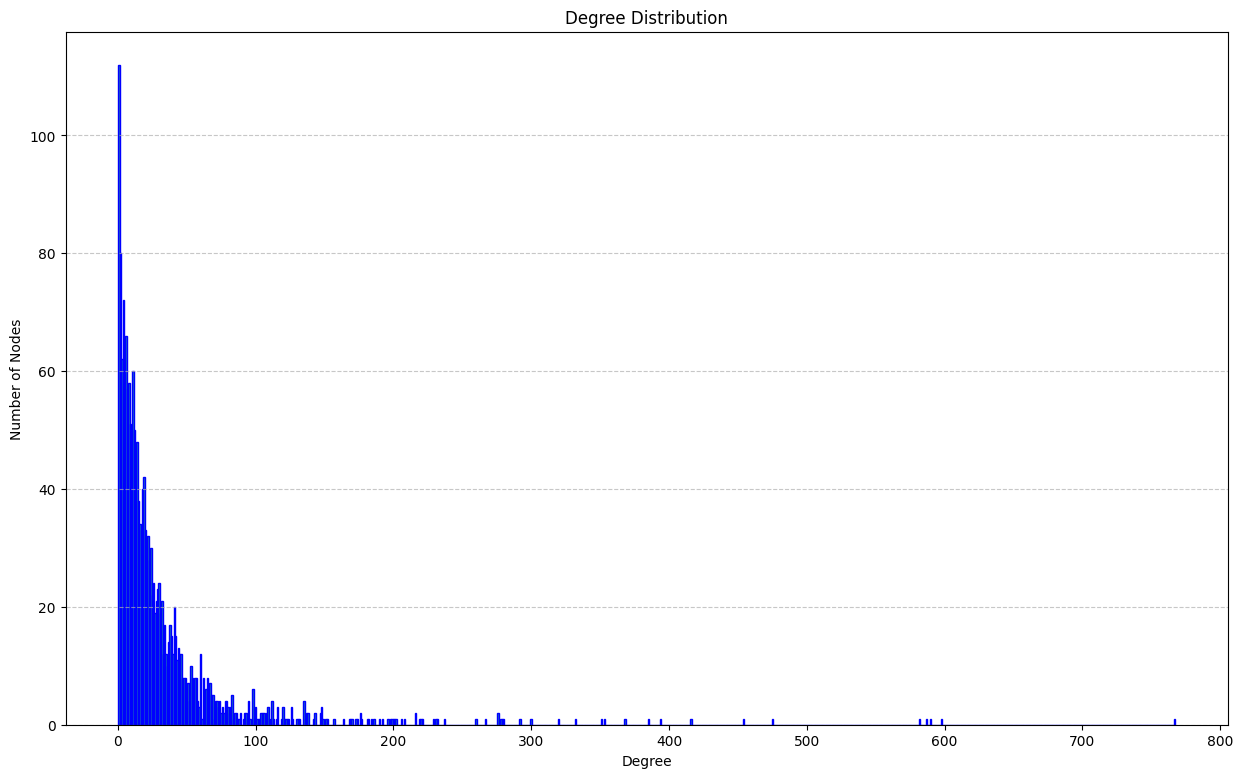

In [12]:
deg = [d for _, d in G.degree()]

plt.figure(figsize=(15, 9))
plt.hist(
    x=deg,
    bins=range(min(deg), max(deg) + 2),
    edgecolor="blue",
    align="left",
)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.grid(
    axis="y",
    linestyle="dashed",
    alpha=0.7,
)
plt.show()

#### Histogram Observations

> The distribution is very skewed which would follow a power-law
> distribution. So, a lot of users have a small amount of friends and towards
> the right side of the graph a few users have a large amount of friends.


#### Average Degree of a Node

In [13]:
avg_deg = np.mean([d for _, d in G.degree()])
print(f"Average Degree of a Node: {avg_deg}")

Average Degree of a Node: 32.73953974895397


#### Average Degree in Dataset Context

> On average, a user has almost **33** friends in the network.

#### Calculate the Average Shortest Path Length Between Any Two Nodes

In [14]:
avg_path_len = [
    np.mean(list(mpl.values()))
    for mpl in min_path_len.values()
]
print(f"Average Shortest Path Length: {np.mean(avg_path_len)}")


Average Shortest Path Length: 2.5310546909192766


#### Average Shortest Path Dataset Context

> On average, a user is **3** friendships away from another user in the network.

#### Plot the Distribution of the Shortest Path Lengths

Text(0, 0.5, 'Frequency (%)')

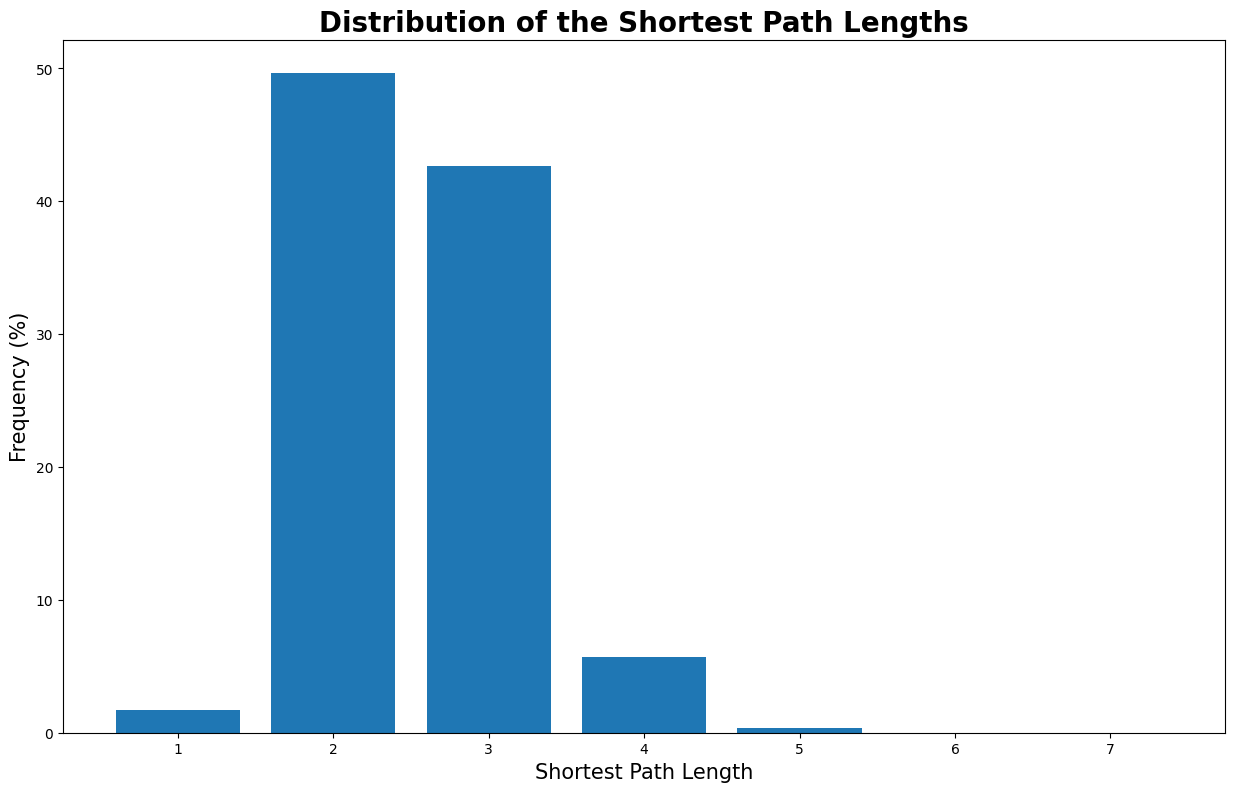

In [15]:
path_len = np.zeros(diameter + 1, dtype=int)

for pls in min_path_len.values():
    pl, cnt = np.unique(list(pls.values()), return_counts=True)
    path_len[pl] += cnt

freq_percent = 100 * path_len[1:] / np.sum(path_len[1:])

fig, ax = plt.subplots(figsize=(15, 9))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    label="Distribution of the Shortest Path Lengths",
    fontdict={
        "fontsize": 20,
        "fontweight": "bold",
    },
    loc="center",
)
ax.set_xlabel(
    xlabel="Shortest Path Length",
    fontdict={
        "fontsize": 15,
    },
)
ax.set_ylabel(
    ylabel="Frequency (%)",
    fontdict={
        "fontsize": 15,
    },
)

#### Shortest Path Histogram Observations

> The majority of the users are from 2 to 3 friends apart. These two
> shortest paths account for around $90\%$ of how far a user is away from
> another user. So, the chance that any pair of users are 5, 6, or 7
> *(7 being the network diameter)* friends apart is rare.

#### Calculate the Edge Density of this Graph

In [16]:
print(f"Edge Density: {nx.density(G)}")

Edge Density: 0.017132150575067492


#### Conclusion on Histogram with Edge Density

> We can conclude that the network is relatively sparse since only around
> $17\%$ of the possible edges are present in the network.

### Load the Node Attribute File and Display the First Few Rows of the Dataset

In [17]:
att_df = spark.read.csv(
    path=os.path.join(DATA_PATH, f"musae_{LANG}_target.csv"),
    header=True,
    inferSchema=True
)

att_df.show(5)

+---------+----+------+------+-------+------+
|       id|days|mature| views|partner|new_id|
+---------+----+------+------+-------+------+
| 44891403|1943| false|929459|   true|  1706|
| 61180621|1633| false| 11194|  false|  1273|
|145109685| 632| false|  2850|  false|   313|
|122121521| 906|  true|  3422|  false|  1570|
|189445819| 267| false|    71|  false|   800|
+---------+----+------+------+-------+------+
only showing top 5 rows


#### Plot a Histogram of the Views

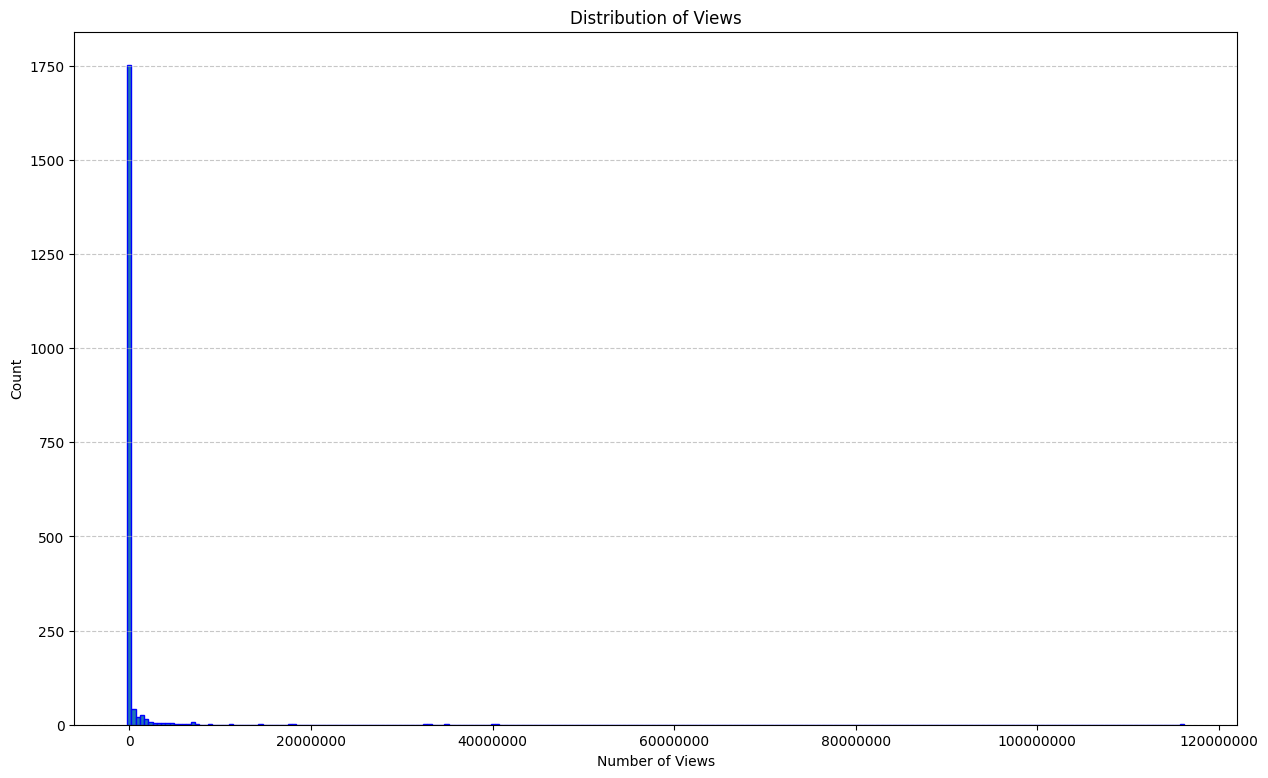

In [18]:
views = att_df.select("Views").rdd.map(lambda x: x[0]).collect()

plt.figure(figsize=(15, 9))
plt.hist(
    x=views,
    bins=250,
    edgecolor="blue",
    align="left",
)
plt.title("Distribution of Views")
plt.xlabel("Number of Views")
plt.ticklabel_format(style="plain")
plt.ylabel("Count")
plt.grid(
    axis="y",
    linestyle="dashed",
    alpha=0.7,
)
plt.show()

Since there is a large skewness in the number of views; A Log Transformation
$log(x + 1)$ was preformed to normalize the data.

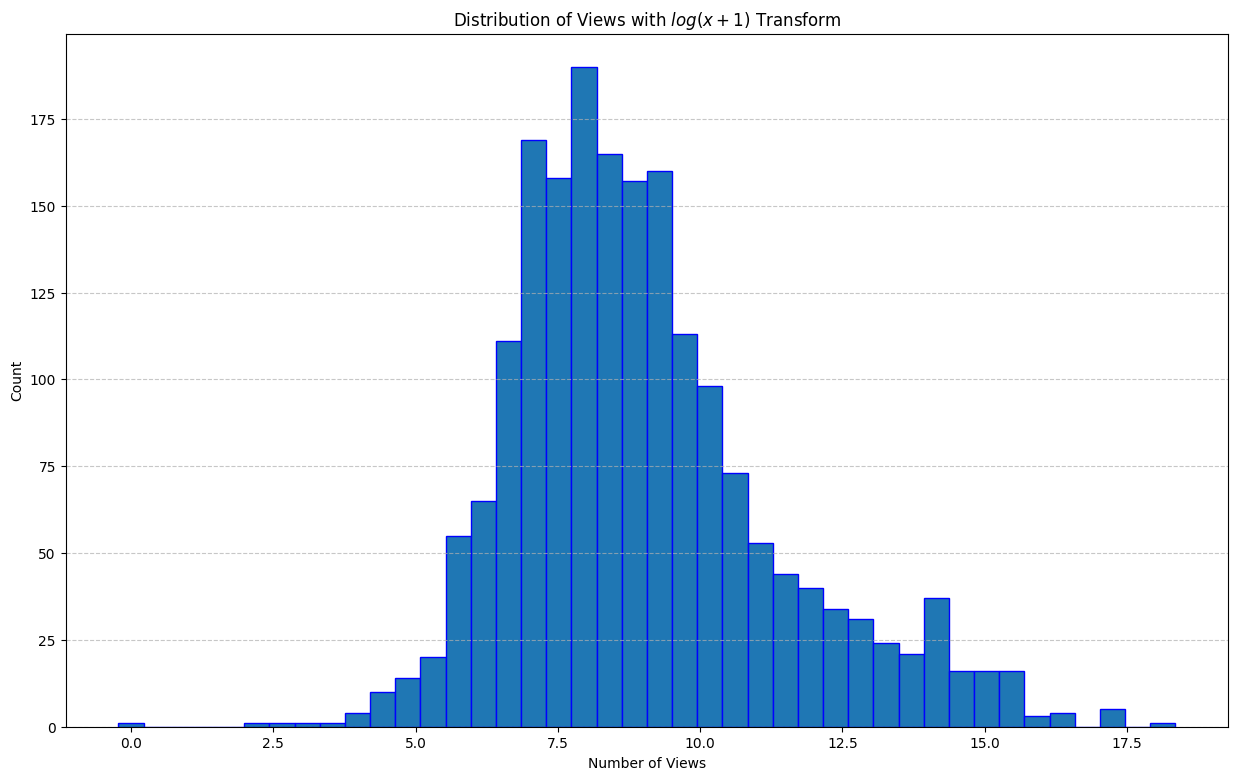

In [19]:
log_views = np.log([v + 1 for v in views])

plt.figure(figsize=(15, 9))
plt.hist(
    x=log_views,
    bins="auto",
    edgecolor="blue",
    align="left",
)
plt.title("Distribution of Views with $log(x+1)$ Transform")
plt.xlabel("Number of Views")
plt.ticklabel_format(style="plain")
plt.ylabel("Count")
plt.grid(
    axis="y",
    linestyle="dashed",
    alpha=0.7,
)
plt.show()

#### Viewer Distribution Observations

> There is a skewness to the distribution, and after the data was normalized
> with a log transformation we are able to see that there are also outliers in
> the dataset.

#### Create a Bar Plot

> Showing the Number of Streamers who are Partners vs. Non-Partners

+-------+-----+
|partner|count|
+-------+-----+
|   true|  279|
|  false| 1633|
+-------+-----+



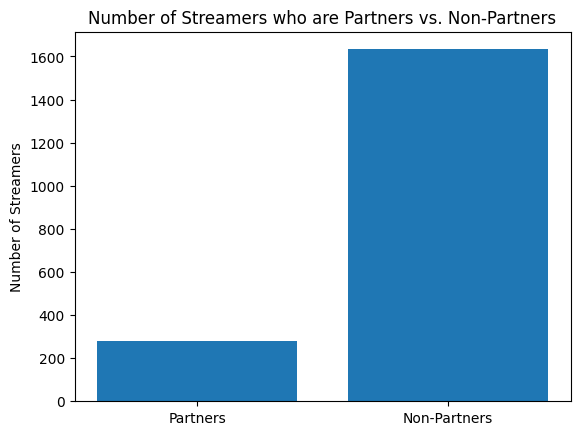

In [20]:
att_df.groupBy("partner").count().show()

plt.bar(
    x = ["Partners", "Non-Partners"],
    height =att_df.groupBy("partner").count().rdd.map(lambda x: x[1]).collect(),
)
plt.title("Number of Streamers who are Partners vs. Non-Partners")
plt.ylabel("Number of Streamers")

plt.show()

#### Partnership Bar Chart Observations

> The proportion of streamers that are partnered make up around $85.4\%$
> of the dataset.

#### Create a Bar Plot

> Showing the Number of Streamers with Mature Content Enabled vs. Not Enabled

+------+-----+
|mature|count|
+------+-----+
|  true|  661|
| false| 1251|
+------+-----+



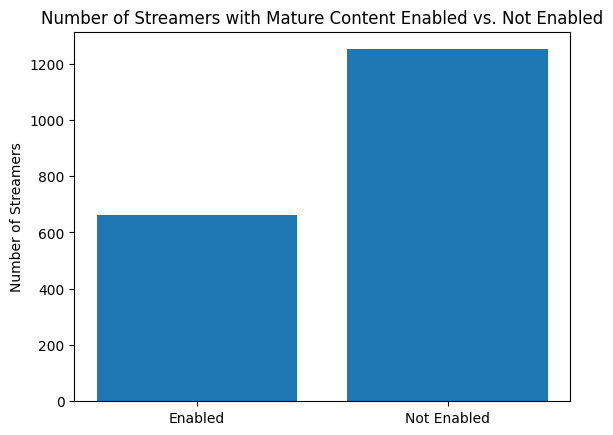

In [21]:
att_df.groupBy("mature").count().show()

plt.bar(
    x=["Enabled", "Not Enabled"],
    height=att_df.groupBy("mature").count().rdd.map(lambda x: x[1]).collect(),
)
plt.title("Number of Streamers with Mature Content Enabled vs. Not Enabled")
plt.ylabel("Number of Streamers")
plt.show()

#### Mature Content Bar Chart Observations

> The majority of streamers do not have mature content enable with a little
> more $65.43\%$ of streamers not enabling mature content.

#### Create a Boxplot Comparing Views by Partner Status



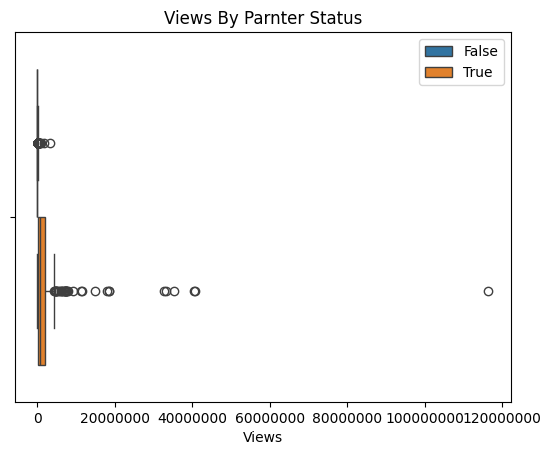

In [22]:
sns.boxplot(
    x=att_df.select("Views").rdd.map(lambda x: x[0]).collect(),
    hue=att_df.select("Partner").rdd.map(lambda x: x[0]).collect(),
)
plt.title("Views By Parnter Status")
plt.xlabel("Views")
plt.ticklabel_format(axis="x", style="plain")
plt.show()

As before we applied the Log Transformation $log(x+1)$ on the number views
to normalized the data.

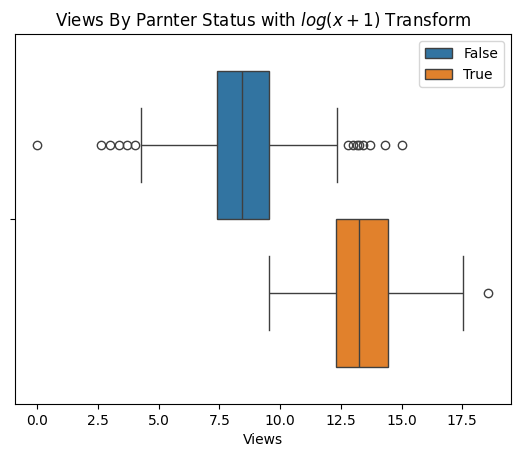

In [23]:
sns.boxplot(
    x=log_views,
    hue=att_df.select("Partner").rdd.map(lambda x: x[0]).collect(),
)
plt.title("Views By Parnter Status with $log(x+1)$ Transform")
plt.xlabel("Views")
plt.show()

#### Views by Partnership Status Boxplot Observations

> The initial boxplot shows that Partners do have higher views than Non-Partners
> by a large margin, this is reforced with boxplot that examines the log
> transformed data.

#### Compute for All Nodes
- Degree Centrality
- Betweenness Centrality
- Closeness Centrality
- Eigenvector Centrality
- PageRank

In [24]:
degree = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)
pagerank = nx.pagerank(G)

In [25]:
centrality_list = [
    {"degree centrality": degree},
    {"betweenness centrality": betweenness},
    {"closeness centrality": closeness},
    {"eigenvector centrality": eigenvector},
    {"pagerank": pagerank},
]

for centrality in centrality_list:
    print(f"Top 10 {list(centrality)[0].title()}")
    centrality_dict = centrality[list(centrality)[0]]
    nodes = sorted(
        centrality_dict.items(),
        key=lambda x: x[1],
        reverse=True
    )[:10]

    for node in nodes:
        print(f"{node[0]}: {node[1]}")
    print()

Top 10 Degree Centrality
127: 0.4013605442176871
1476: 0.3129251700680272
290: 0.3087388801674516
1297: 0.30716902145473574
467: 0.304552590266876
1660: 0.24856096284667714
67: 0.23757195185766616
1320: 0.217687074829932
1758: 0.20617477760334904
1259: 0.20146520146520147

Top 10 Betweenness Centrality
127: 0.0992613670254655
1476: 0.054894872658417665
1297: 0.05042095543765276
290: 0.05011201385679391
467: 0.04382473622801392
67: 0.034425706705748176
1660: 0.02624664025473586
1259: 0.023294665516722747
287: 0.022120764244835684
428: 0.021980008718637752

Top 10 Closeness Centrality
127: 0.6009433962264151
1297: 0.5684116597263533
467: 0.565050266114725
290: 0.5595900439238654
1476: 0.5594262295081968
67: 0.5435153583617748
1660: 0.5416666666666666
1593: 0.5295095594347464
1259: 0.5237051246916964
287: 0.5227024070021882

Top 10 Eigenvector Centrality
127: 0.17877831012617343
1297: 0.15866803272155214
467: 0.1572393891554249
290: 0.15150156437553064
1476: 0.1457607576802339
1660: 0.133

#### Observations on Centrality Measures and PageRank

> Looking across the measures node $127$ is at the top of each measure.

> Nodes $67, 290, 467, 1297, 1476$ and $1660$ appearing in the top $7$ of each
> measure.

> Nodes $1320$ and $1758$ appears in *Degree* and *Eigenvector*
> centralities and *PageRank*, where node $1259$ appears across all measures
> except for *Eigenvector* cetrality.

> Node $1593$ is in the top 10 for only *Closeness* and *Eigenvector*
> centralities. Node $287$ is only in the top 10 for *Betweeness* and
> *Closeness* centralities.

> Finally, node $428$ is only in the top 10 *Betweenness* centrality across all
> the centralities and PageRank.

#### Create Boxplots Comparing Centralities and PageRang Values Between Partner Streamers and Non-Partner Streamers

Create the dataframe by joining the attributes data with centrality dictionary.

- Create PySpark dataframe from the centrality dictionary
- Join the dataframe to the attributes data to established partnership
- Visualize the boxplot for each centrality

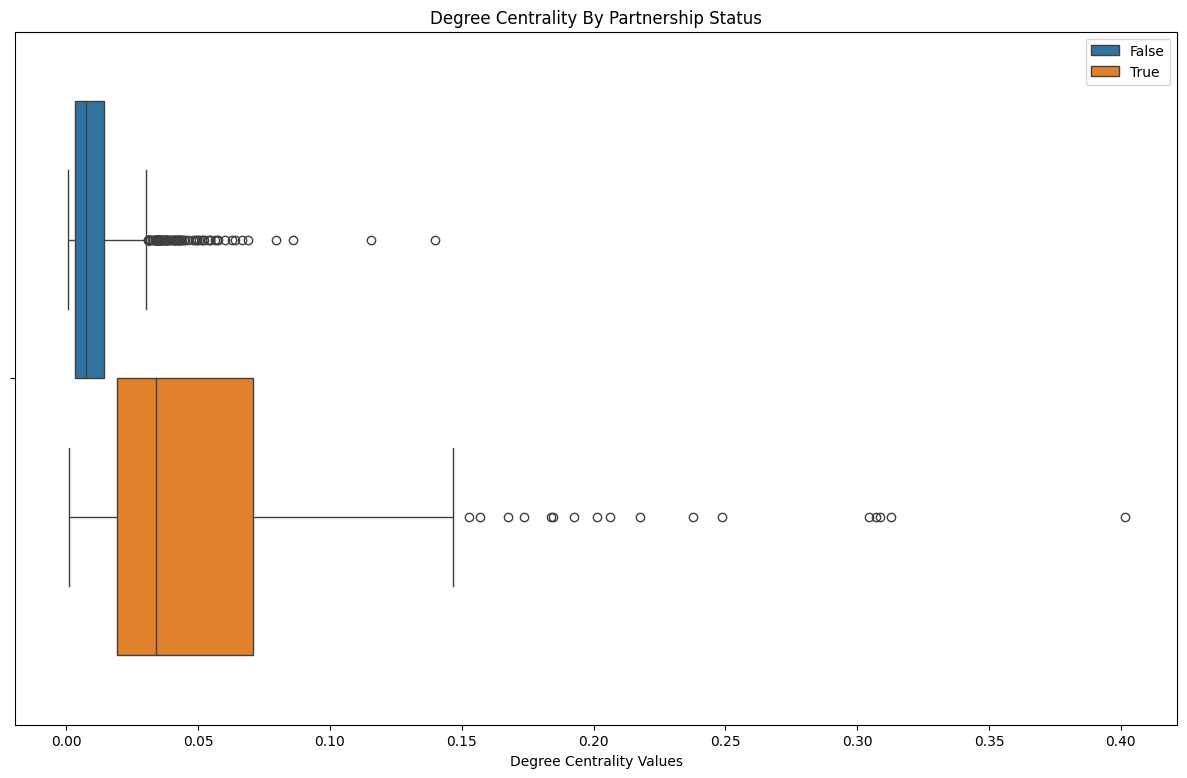

In [26]:
cent_df = spark.createDataFrame(
    degree.items(), ["node", "centrality"])
cent_df = cent_df.join(
    other=att_df.select("new_id", "Partner"),
    on=[cent_df.node == att_df.new_id],
    how="inner",
)
plt.figure(figsize=(15, 9))
sns.boxplot(
    x=cent_df.select("centrality").rdd.map(lambda x: x[0]).collect(),
    hue=cent_df.select("partner").rdd.map(lambda x: x[0]).collect(),
)
plt.title("Degree Centrality By Partnership Status")
plt.xlabel("Degree Centrality Values")
plt.show()

#### Degree Centrality Boxplot

> The partnered streamers have a lot more direct friendships than the
> non-partnered streamers. From the boxplot for *degree centrality* the largest > outlier in the non-partnered streamers would not be an outlier among the
> partnered streamers, and a majority of the non-partnered outliers would fall
> below the third quartile $Q3$ of the partnered streamer group.

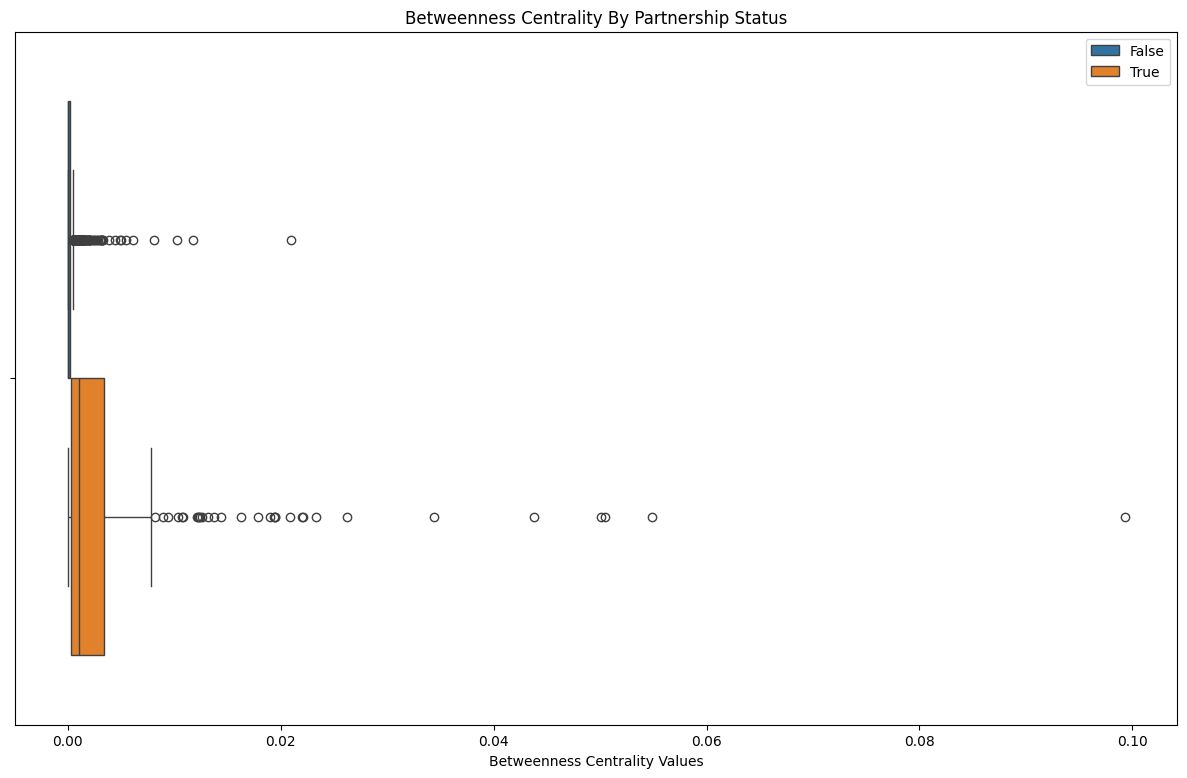

In [27]:
cent_df = spark.createDataFrame(
    betweenness.items(), ["node", "centrality"])
cent_df = cent_df.join(
    other=att_df.select("new_id", "Partner"),
    on=[cent_df.node == att_df.new_id],
    how="inner",
)
plt.figure(figsize=(15, 9))
sns.boxplot(
    x=cent_df.select("centrality").rdd.map(lambda x: x[0]).collect(),
    hue=cent_df.select("partner").rdd.map(lambda x: x[0]).collect(),
)
plt.title("Betweenness Centrality By Partnership Status")
plt.xlabel("Betweenness Centrality Values")
plt.show()

#### Betweenness Centrality Boxplot

> From the boxplot for *betweenness centrality* the partnered streamers are
> more important connecting to other user than the non-partnered streamers even
> though the betweenness in either group is not large.

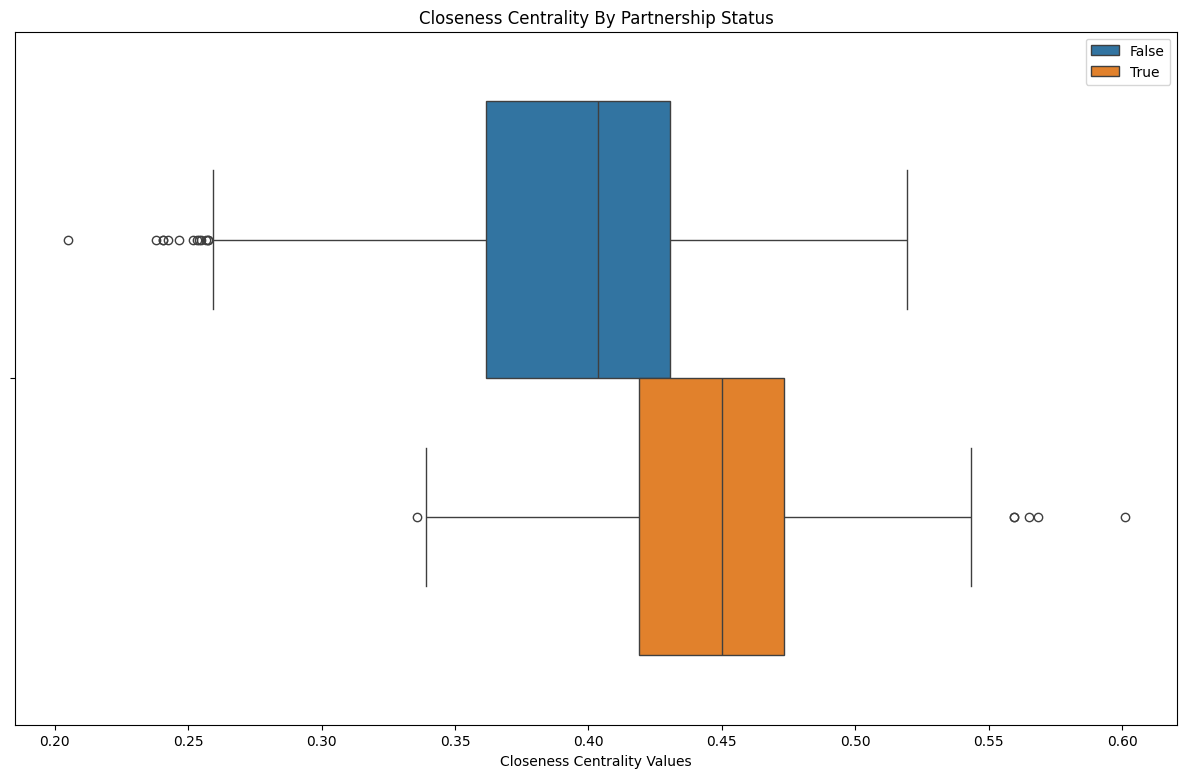

In [28]:
cent_df = spark.createDataFrame(
    closeness.items(), ["node", "centrality"])
cent_df = cent_df.join(
    other=att_df.select("new_id", "Partner"),
    on=[cent_df.node == att_df.new_id],
    how="inner",
)
plt.figure(figsize=(15, 9))
sns.boxplot(
    x=cent_df.select("centrality").rdd.map(lambda x: x[0]).collect(),
    hue=cent_df.select("partner").rdd.map(lambda x: x[0]).collect(),
)
plt.title("Closeness Centrality By Partnership Status")
plt.xlabel("Closeness Centrality Values")
plt.show()

#### Closeness Centrality Boxplot

> The *closeness centrality* boxplot shows that partnered streamers have a
> greater ability to reach other users than the non-partnered streamers.

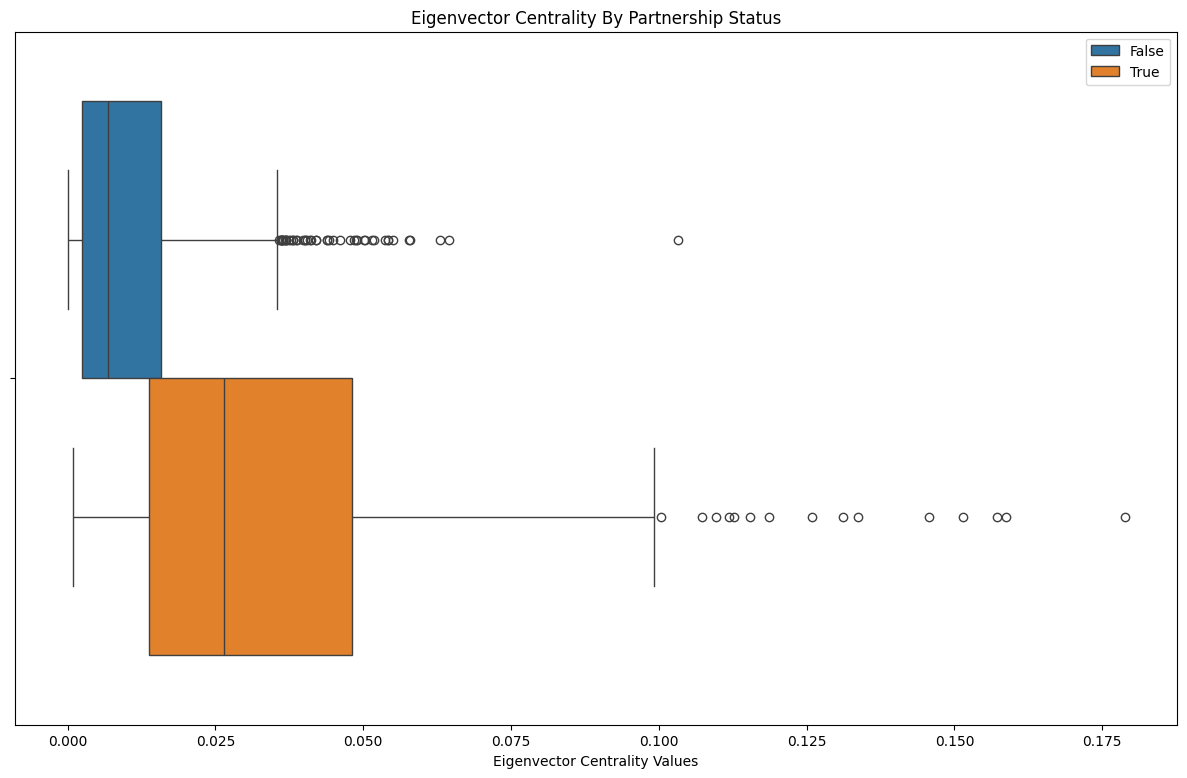

In [29]:
cent_df = spark.createDataFrame(
    eigenvector.items(), ["node", "centrality"])
cent_df = cent_df.join(
    other=att_df.select("new_id", "Partner"),
    on=[cent_df.node == att_df.new_id],
    how="inner",
)
plt.figure(figsize=(15, 9))
sns.boxplot(
    x=cent_df.select("centrality").rdd.map(lambda x: x[0]).collect(),
    hue=cent_df.select("partner").rdd.map(lambda x: x[0]).collect(),
)
plt.title("Eigenvector Centrality By Partnership Status")
plt.xlabel("Eigenvector Centrality Values")
plt.show()

#### Eigenvector Centrality Boxplot

> The *Eigenvector centrality* boxplot shows that partnered streamers are more
> influential than non-partnered streamers. The maximum and a majority of the
> non-partnered streamers outliers still fall below the third quartile $Q3$ of
> the partnered streamers showing us that partnered streamers are influenctial.

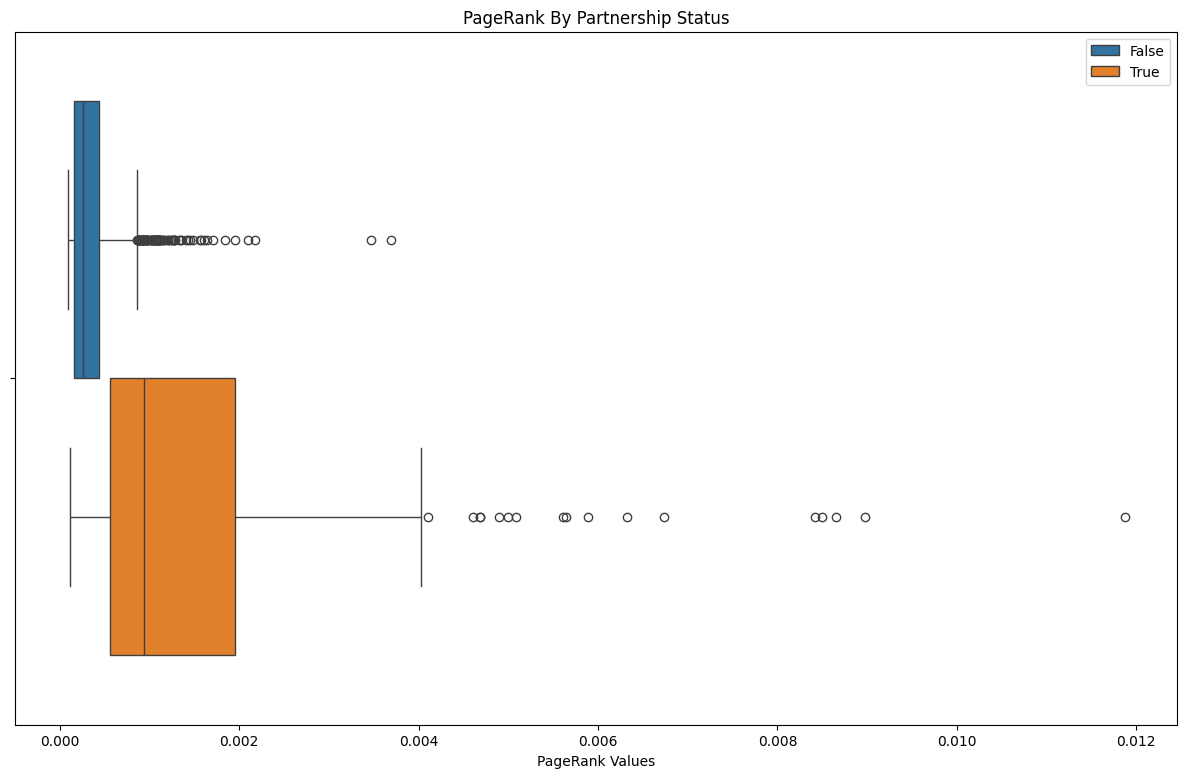

In [30]:
cent_df = spark.createDataFrame(
    pagerank.items(), ["node", "centrality"])
cent_df = cent_df.join(
    other=att_df.select("new_id", "Partner"),
    on=[cent_df.node == att_df.new_id],
    how="inner",
)
plt.figure(figsize=(15, 9))
sns.boxplot(
    x=cent_df.select("centrality").rdd.map(lambda x: x[0]).collect(),
    hue=cent_df.select("partner").rdd.map(lambda x: x[0]).collect(),
)
plt.title("PageRank By Partnership Status")
plt.xlabel("PageRank Values")
plt.show()

#### PageRank Boxplot

> The *PageRank* boxplot shows us that partnered streamers are more important to
> the friendships in the network than non-partnered streamers. Again, this is
> very heavily favored towards partnered streamers against non-partnered
> streamers.

#### Apply the Louvain Community Detection Algorithm Report the Number of Communities

> After reading the documentation on NetworkX Louvain Community Algorithms:
> - louvain_communities: returns the last iteration of the algorithms
> - louvain_partitions: yields all iterations
>   - Converting to a list results the same as louvain_communities

*Note: A seed was set for both of the algorithms*

In [31]:
communities = nx.community.louvain_communities(G, seed=SEED)
print(f"Number of Communities: {len(communities)}")

Number of Communities: 6


In [32]:
partitions = list(nx.community.louvain_partitions(G, seed=SEED))
print(f"Number of Partitions: {len(partitions)}")
print(f"Number of Partitions: {len(partitions[-1])}")

Number of Partitions: 3
Number of Partitions: 6


#### There are $6$ communities from the Louvian community detection algorithm.

In [33]:
print("Nodes Per Community")
for p, c in zip(partitions[-1], communities):
    print(f"Partition Algorithm:{len(p)}")
    print(f"Community Algorithm:{len(c)}")
    print()

Nodes Per Community
Partition Algorithm:96
Community Algorithm:96

Partition Algorithm:374
Community Algorithm:374

Partition Algorithm:485
Community Algorithm:485

Partition Algorithm:304
Community Algorithm:304

Partition Algorithm:437
Community Algorithm:437

Partition Algorithm:216
Community Algorithm:216



#### Compute the Average Views and Days per Community

Converting the list of sets to a dictionary with a community value.

In [34]:
comm_dict = {}
for c in range(len(communities)):
    print(f"Current Node Count in Dictionary: {len(comm_dict)}")
    print(f"Adding Comminuity {c + 1} Nodes: {len(communities[c])}")
    comm_dict.update(
        {(node, c + 1) for node in list(communities[c])}
    )
    print(f"New Node Count in Dictionary: {len(comm_dict)}\n")

Current Node Count in Dictionary: 0
Adding Comminuity 1 Nodes: 96
New Node Count in Dictionary: 96

Current Node Count in Dictionary: 96
Adding Comminuity 2 Nodes: 374
New Node Count in Dictionary: 470

Current Node Count in Dictionary: 470
Adding Comminuity 3 Nodes: 485
New Node Count in Dictionary: 955

Current Node Count in Dictionary: 955
Adding Comminuity 4 Nodes: 304
New Node Count in Dictionary: 1259

Current Node Count in Dictionary: 1259
Adding Comminuity 5 Nodes: 437
New Node Count in Dictionary: 1696

Current Node Count in Dictionary: 1696
Adding Comminuity 6 Nodes: 216
New Node Count in Dictionary: 1912



Creating a dataframe with communities and combining to attribute data

In [35]:
comm_df = spark.createDataFrame(
    comm_dict.items(), ["node", "community"])

comm_df = comm_df.join(
    other=att_df.select("new_id", "Views", "Days"),
    on=[comm_df.node == att_df.new_id],
    how="inner",
)
comm_df.show(5)

+----+---------+------+------+----+
|node|community|new_id| Views|Days|
+----+---------+------+------+----+
|  80|        1|    80|  9889|2284|
|  34|        1|    34|  6126| 719|
| 507|        1|   507|187209| 809|
| 586|        1|   586|  3470|2332|
|1343|        1|  1343|   294|1753|
+----+---------+------+------+----+
only showing top 5 rows


Create the dataframe with communities, average views, and average per day usage.

In [88]:
window = Window.partitionBy()

comm_avg_df = comm_df.groupBy("community") \
    .agg(
        F.count("community").alias("community_count"),
        F.round(F.avg("Views"), 6).alias("avg_views"),
        F.sum("Days").alias("per_day"),
        F.round(F.avg("Days"), 6).alias("avg_per_days"),
    ) \
    .withColumn(
        "percent_avg_views",
        F.round(
            F.col("avg_views")
            / F.sum("avg_views").over(window), 4).cast(T.DoubleType())
            * 100
    ) \
    .withColumn(
        "percent_per_day",
        F.round(
            F.col("per_day")
            / F.sum("per_day").over(window), 4).cast(T.DoubleType())
            * 100
    ) \
    .withColumn(
        "percent_avg_days",
        F.round(
            F.col("avg_per_days")
            / F.sum("avg_per_days").over(window), 4).cast(T.DoubleType())
            * 100
    ) \
    .orderBy("community")

comm_avg_df.show()

+---------+---------------+--------------+-------+------------+-----------------+------------------+------------------+
|community|community_count|     avg_views|per_day|avg_per_days|percent_avg_views|   percent_per_day|  percent_avg_days|
+---------+---------------+--------------+-------+------------+-----------------+------------------+------------------+
|        1|             96| 293829.479167| 166889| 1738.427083|            12.02|              6.58|20.669999999999998|
|        2|            374| 212264.254011| 457668|  1223.71123|             8.68|18.029999999999998|14.549999999999999|
|        3|            485| 272537.934021| 675075| 1391.907216|            11.15|              26.6|             16.55|
|        4|            304|1291529.848684| 402944| 1325.473684|            52.82|15.879999999999999|             15.76|
|        5|            437| 308141.036613| 485237| 1110.382151|             12.6|             19.12|13.200000000000001|
|        6|            216|  66690.79166

#### Average Views and Per Day Usage Per Community Observations

> Community $1$ with $96$ user accounts is the smallest community with
> $12.02\%$ of average views, but has the highest average per day with around
> $20.67\%$. This group accounts for $6.58\%$ of days.

> Community $2$ with $374$ users has one of the lowest average views with a
> third largest community at $8.68\%$, and has the second lowest per day with
> $14.56\%$. This group accounts for $18.03\%$ of days.

> Community $3$ with $485$ users is the largest community. The views and per day
> averages are in the middle of the pack with $11.15\%$ and $16.55\%$
> respectively. This group accounts for $26.60\%$ of days.

> Community $4$ with $304$ users leads average views by a massive margin with
> $52.82\%$ of all views, but has less average per day than communities $1, 3$
> and $6$ with only around $15.88\%$. This group accounts for $18.03\%$ of days.

> Community $5$ with $437$ users is the second largest community with an average
> $12.60\%$ of all views, but has the lowest average per day with only
> $13.20\%$. This group accounts for $19.12\%$ of days.

> Community $6$ with $216$ users is the second smallest community, and has the
> lowest average views with only $2.73\%$ of all views, but has the second
> highest average per day with around $19.28\%$. This group accounts for
> $13.80\%$ of days.

> So from the table and information above, it would appear that communities
> $1$ and $6$ have the highest per day average in their community. Community $4$
> leads with the most views from a smaller user pool, and community $3$ with the
> largest user group lead for per day usage, but only the third highest average
> per day usage.

### End of Project